In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import  nangs 
import  torch
#import cv2
import io

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.06', '1.11.0+cpu')

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

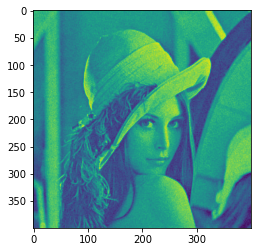

In [3]:
import  matplotlib
image_test = matplotlib.image.imread('D:\\escuela\\WPy64-31040\\hope.jpg')
plt.imshow(image_test)


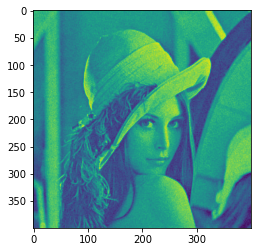

In [4]:
import  matplotlib
image_test = matplotlib.image.imread('D:\\escuela\\WPy64-31040\\hope.jpg')
plt.imshow(image_test)


[[174 168 166 ... 177 173 150]
 [177 170 165 ... 182 163 125]
 [183 175 169 ... 183 167 129]
 ...
 [ 62  62  61 ...  64  67  63]
 [ 49  59  66 ...  71  77  68]
 [ 50  52  66 ...  75  83  68]]
(200, 200)
uint8


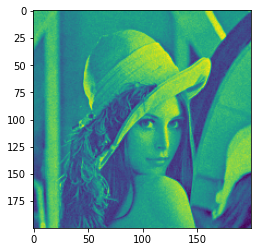

In [5]:
import cv2
img=cv2.imread("D:\\escuela\\WPy64-31040\\hope.jpg", cv2.IMREAD_GRAYSCALE)
print(img)

dim = (200, 200)
  
# resize image
initial_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
# initial_img = cv2.resize(poisson_noise, dim, interpolation = cv2.INTER_AREA)

#io.imsave("initial_image.jpg", initial_img)
print(initial_img.shape)
print(initial_img.dtype)

plt.imshow(initial_img)

In [6]:
from nangs import PDE
import math

K=50

class PeronaMalik(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        
        # compute first-order derivatives
        grads = self.computeGrads(outputs, inputs)
        dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        
        # compute second-order derivatives
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0]        
        dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        #dudas
        dp2dpxdpy=self.computeGrads(dpdx, inputs)[:, 1]
        dp2dpydpx=self.computeGrads(dpdy, inputs)[:, 0]
        
        
        # compute loss
        #dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        return {'pde': dpdx*(-2/K**2)*torch.exp(-(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2)  *((dpdx*dp2dx2)+(dpdy*dp2dpydpx))
                      -dpdy*(-2/K**2)*torch.exp(-(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2)  *((dpdx*dp2dpxdpy)+(dpdy*dp2dy2))
               +torch.exp(  -(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2) * ( dp2dx2+dp2dy2 )-dpdt}
    
pde = PeronaMalik(inputs=('x', 'y', 't'), outputs='p')

In [7]:
import torch
import random


class BaseSampler():
    def __init__(self, data, n_samples=1, device="cpu"):
        assert isinstance(data, dict), "you must pass a dict with your data"
        self.device = device
        self.data = data
        self.vars = tuple(data.keys())
        self.n_samples = n_samples

    def _sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        sample = self.sample(n_samples)
        return torch.stack([
            sample[var]
            for var in self.vars
        ], axis=-1)

    def sample(self, n_samples=None):
        raise ValueError("you must implement this method")
    
    



class Perona_Sampler(BaseSampler):
    def __init__(self, data, n_samples=1, device="cpu"):
        super().__init__(data, n_samples, device)
        for var, lims in data.items():
            if isinstance(lims, list):
                assert len(
                    lims) == 2, "you must pass a list with the min and max limits"
            elif isinstance(lims, int) or isinstance(lims, float):
                data[var] = [lims, lims]
            else:
                raise ValueError("invalid limits")

    def sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        a={
            
            var: torch.rand(n_samples, device=self.device) *
            (lims[1] - lims[0]) + lims[0]
            for var, lims in self.data.items()
        }
        i=0
        b_list=[]
        for item in range(n_samples):
            b=random.uniform(0,200)
            if i<-1:
                b_list.append(0)
            else:
                b_list.append(b)
            i+=1
            #print(i,b)
            
        
        b_tensor=torch.tensor(b_list,device=self.device)
        #for i in b_tensor:
        #    b_tensor[i]=b
        result={'x':a['x'],'y':a['y'],'t':b_tensor}  
        
        if random.randint(0,100)<=1:
            print(result)
        return result
    
    
class Perona_Sampler_Ini(BaseSampler):
    def __init__(self, data, n_samples=1, device="cpu"):
        super().__init__(data, n_samples, device)
        for var, lims in data.items():
            if isinstance(lims, list):
                assert len(
                    lims) == 2, "you must pass a list with the min and max limits"
            elif isinstance(lims, int) or isinstance(lims, float):
                data[var] = [lims, lims]
            else:
                raise ValueError("invalid limits")

    def sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        a={
            
            var: torch.rand(n_samples, device=self.device) *
            (lims[1] - lims[0]) + lims[0]
            for var, lims in self.data.items()
        }
        i=0
        b_list=[]
        for item in range(n_samples):
            b=random.uniform(0,200)
            if i<n_samples/10:
                b_list.append(0)
            else:
                b_list.append(b)
            i+=1
            #print(i,b)
            
        
        b_tensor=torch.tensor(b_list,device=self.device)
        #for i in b_tensor:
        #    b_tensor[i]=b
        result={'x':a['x'],'y':a['y'],'t':b_tensor}  
        #print(result)
        return result


In [8]:
n_samples = 80000
print("a")

a


In [9]:
# define the sampler

from nangs import RandomSampler

sampler = Perona_Sampler({
    'x': [0., 200.], 
    'y': [0., 200.],
    't': [0., 200.], 
}, device=device, n_samples=1000)

pde.set_sampler(sampler)
print("a")

a


In [10]:


def initial_condition_Adr(x,y):
    res = torch.zeros(len(x))
    for i in range(len(x)):
        if len(x) == 1:
            res[i] = initial_img[int(x.item()),int(y.item())]
        else:
            res[i]=(initial_img [int(x[i]),int(y[i])])
        #print(res)
    #print("hey")
    #print(res)        
    return res

In [11]:
def cero_f(x,y):
    res = torch.zeros(len(x))
    for i in range(0,len(x)):
        res[i]=0
    return res

In [12]:
def cero_f(n_samples):
    return torch.zeros(n_samples)

In [13]:
def f_circle(x,y):
    z = (x - 100)**2 + (y - 100)**2
    for i in range(0,len(z)):
        if z[i] <= 800:
            z[i] = 30
        else: z[i] = 200

    return z

In [14]:
def cart_prod(*args):
    grids =np.meshgrid(*args,indexing='ij')
    return np.stack(grids,axis=-1).reshape(-1,len(args))

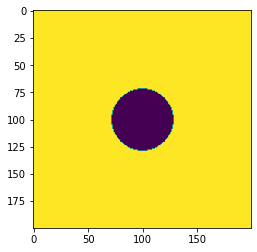

In [15]:
x = np.linspace(0,199,200)

grid=cart_prod(x,x)


xs, ys= grid[:, 0:1], grid[:,1:2]
ini_circle=f_circle(xs,ys).reshape(200,200)

plt.imshow(ini_circle)


In [16]:
from nangs import Dirichlet



foto = Dirichlet(
    Perona_Sampler({'x': [0., 200.], 'y': [0., 200.],'t':0}, device=device, n_samples=n_samples), 
     lambda inputs: {'p' :f_circle(inputs['x'],inputs['y'])},
    name="foto"
)
#print(temp)
                           
pde.add_boco(foto)
print("a")

a


In [17]:
import torch


class Sine(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)


def block(i, o):
    fc = torch.nn.Linear(i, o)
    return torch.nn.Sequential(
        Sine(),
        torch.nn.Linear(i, o)
    )


class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons):
        super().__init__()
        
        fc_in = torch.nn.Linear(inputs, neurons)
        fc_hidden = [
            block(neurons, neurons)
            for layer in range(layers-1)
        ]
        fc_out = block(neurons, outputs)

        self.mlp = torch.nn.Sequential(
            fc_in,
            *fc_hidden,
            fc_out
        )

    def forward(self, x):
        return self.mlp(x)
    
    #def anzatc(self, u, xs):
    #    """ Anzatc-transformation of the model-output needed for binding initial and boundary conditions. """
    #    # Get tensor of spatial variables and time-tensor.
    #    xs_spatial = xs[:, :self.ndims_spatial]
    #    t = xs[:, self.ndims - 1:self.ndims]
    #    lower, upper = [lims[0] for lims in self.domain], [lims[1] for lims in self.domain]
    #    lower_spatial, upper_spatial = [torch.Tensor(lst[:self.ndims_spatial]).reshape(1, -1).float()
    #                                    for lst in (lower, upper)]
    #    t0 = lower[-1]

        # Apply transformation to bind the boundary condition.
    #    if self.boundary_condition is not None:
    #        u = (u * (torch.prod((xs_spatial - lower_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True) *
    #                  torch.prod((upper_spatial - xs_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True))
    #                 + self.boundary_condition)

        # Apply transformation to bind the initial condition.
    #    if self.initial_condition is not None:
    #        _xs_spatial = [xs_spatial[:, i] for i in range(xs_spatial.shape[1])]
    #        u = ((nn.Sigmoid()((t - t0) / torch.exp(self.log_scale)) - .5) * u
    #             + self.initial_condition(*_xs_spatial).view(-1, 1))
    #    return u

In [18]:
# solve

#from nangs import MLP

LR = 1e-2
N_STEPS = 800
NUM_LAYERS = 3
NUM_HIDDEN = 128
print(len(pde.inputs))
print(len(pde.outputs))

for item in pde.inputs:
    print(item)
for item in pde.outputs:
    print(item)
    
    
mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

3
1
x
y
t
p


  0%|                                                                                          | 0/800 [00:00<?, ?it/s]

{'x': tensor([ 85.9275, 166.2255,  33.4503,  59.1809, 151.8790,  84.6403, 155.6921,
         68.4663, 122.7539, 191.5623, 116.2485, 131.1385,  99.5664,  16.0074,
          4.5310,  64.5264, 149.0920,   6.4139,  36.7222,  90.4126,  37.0038,
         68.8843, 175.3896, 100.2524,  25.3740,  82.2061,  51.9706, 169.5281,
        147.9687,  30.6341,  35.6140,  35.9739, 162.4270, 148.4478, 181.3048,
         73.4795,  76.1727, 105.4463,   5.6316, 135.3836, 125.5124, 169.8547,
         60.9374, 150.9760, 123.5270, 101.3024, 199.2175,  57.0965, 145.6177,
         82.8587, 142.1661,  55.5324, 175.8725,  69.4064, 104.6400,  33.1555,
         17.2301, 154.4642,  15.1218, 119.0126, 115.6095,  57.5729,  36.8133,
        153.9917,  77.0668, 126.3445,  58.7126,   0.5841, 141.4309, 102.5964,
         67.8690,  38.3868,  59.9966, 139.1140, 187.6568, 113.1195, 162.7277,
        152.6616,  58.2517,   3.3889, 120.1588, 126.8121,   9.6870,  90.7690,
         68.8854,  85.0670,  36.0903,   5.5292, 179.1241, 

  1%|▊                                                                               | 8/800 [00:39<1:05:52,  4.99s/it]

{'x': tensor([1.2773e+02, 1.8183e+02, 9.3063e+01, 9.3132e+01, 1.5300e+02, 1.2913e+02,
        1.4682e+02, 9.8070e+01, 1.2703e+01, 1.1764e+02, 9.6630e+01, 1.9704e+02,
        5.1933e+01, 1.6238e+02, 1.9050e+02, 1.2117e+02, 1.8414e+02, 3.4906e+01,
        1.5232e+02, 1.6418e+01, 1.8983e+02, 9.4720e+00, 2.3209e+01, 1.5982e+02,
        3.5761e+01, 6.3056e+01, 1.5911e+02, 1.6863e+02, 6.4946e+01, 1.0288e+02,
        1.1409e+01, 1.9000e+02, 1.4199e+02, 5.0017e+01, 1.1418e+02, 4.8322e+01,
        5.3941e+01, 3.6381e+01, 9.2009e+01, 5.4376e+01, 8.6457e+01, 1.5249e+02,
        1.5769e+02, 9.7181e+01, 1.4199e+01, 1.4081e+02, 1.8248e+02, 4.6014e+01,
        6.2940e+01, 3.1949e+01, 3.5630e+01, 1.9192e+02, 8.9167e+01, 1.7543e+02,
        7.7551e+01, 1.5531e+02, 9.6706e+01, 4.2790e+01, 8.6249e+01, 1.3171e+02,
        5.3246e+01, 1.0260e+02, 1.1783e+02, 3.9920e+00, 1.5501e+02, 1.1868e+02,
        1.6022e+02, 1.9244e+02, 7.8529e+01, 1.5993e+02, 1.1235e+02, 6.6123e+01,
        2.2670e+01, 1.5446e+01, 1.

  4%|███▏                                                                             | 32/800 [02:05<37:28,  2.93s/it]

{'x': tensor([143.6414, 118.0324,  79.1578,  ...,  68.8925, 156.2955, 178.7277]), 'y': tensor([ 17.5039,  78.4070, 141.5186,  ..., 153.8282, 143.1789,  20.5392]), 't': tensor([128.4076, 135.1728,   8.3337,  ..., 152.4159,  11.5941, 146.0550])}


  5%|████▏                                                                            | 41/800 [02:33<38:09,  3.02s/it]

{'x': tensor([137.0971,  42.2414,  34.2917,  ..., 151.3166, 148.8264,   8.8137]), 'y': tensor([ 15.9992, 164.9910,  89.1754,  ...,   6.4384, 199.0749,  70.1908]), 't': tensor([157.6723, 153.4173, 187.2581,  ..., 101.7286,  94.5750, 139.3459])}


  6%|█████                                                                            | 50/800 [03:01<40:42,  3.26s/it]

{'x': tensor([ 56.9697, 137.9294, 142.2756, 139.5496, 162.6194, 175.4141,   3.0384,
        179.3037,  39.4116,  40.7433,   5.4956, 128.2681, 184.8084,  83.2508,
        165.6520,   3.3738,  76.3188, 151.0969, 152.1133,  31.0441, 168.3553,
        130.0024, 110.9262, 129.0453,  45.3060,  30.3992, 192.1041,  17.3879,
         33.4632, 174.7395, 161.3236, 153.1652, 190.0651, 167.1577, 115.3625,
        175.1056, 155.6830, 181.8143, 101.5029,  34.2121, 110.8426, 106.3256,
         34.6977, 118.6434,  12.6334,  98.8493,  52.2040, 197.0998, 173.9364,
         27.1513, 146.3637,  55.6896, 137.6984,  84.9786,  26.8945, 141.4140,
        107.3736, 146.1221, 192.3056, 118.7400, 104.4623,  93.1474,  20.2606,
         90.1779, 184.2341, 167.0897,   8.3517, 195.4480,  37.0911,  21.6787,
        121.6890,  28.8216, 158.2020, 173.0790, 194.2404,  39.0075, 189.1219,
        175.5191,  45.8878, 191.8305, 181.5364,  13.6053, 176.3791,  98.4987,
         65.9941, 140.9995,  57.8637,  24.6747,   9.1408, 

  6%|█████▎                                                                           | 52/800 [03:08<42:55,  3.44s/it]

{'x': tensor([181.6483, 142.0934,  87.6426,  ..., 188.7892,  58.5489,  84.3591]), 'y': tensor([ 60.6620, 114.5764,  86.0204,  ...,  39.0127,  23.0945,  20.6155]), 't': tensor([ 11.3324, 155.9001,  20.0568,  ...,  73.0780,  81.2465,  21.5663])}


 11%|████████▌                                                                        | 85/800 [05:18<53:18,  4.47s/it]

{'x': tensor([8.2991e+01, 1.2511e+02, 1.8556e+02, 7.0990e+01, 6.1863e+01, 7.0991e+01,
        1.1233e+02, 1.4189e+02, 9.6797e+01, 1.9173e+01, 5.4404e+01, 9.9111e+01,
        6.6682e+01, 4.9209e+01, 1.9632e+02, 6.0048e+00, 9.4301e+01, 9.2646e+01,
        1.6837e+02, 9.6244e+01, 1.5801e+02, 1.2037e+00, 1.9141e+02, 7.4966e+01,
        1.1256e+02, 8.6883e+01, 1.2538e+02, 1.0753e+02, 1.3712e+02, 1.1798e+02,
        6.7248e+01, 2.5434e+01, 4.9146e+01, 1.5577e+01, 7.3471e+01, 1.5758e+02,
        2.2044e+01, 1.4012e+02, 9.9970e+01, 3.8866e+01, 1.5308e+02, 7.4168e+01,
        8.9118e+01, 2.0683e+01, 1.4135e+02, 5.5757e+01, 1.6424e+02, 4.0210e+01,
        1.3618e+02, 1.2223e+01, 1.7334e+02, 1.9891e+02, 1.0575e+02, 8.1976e+01,
        7.7729e+01, 1.2830e+02, 9.3660e+01, 2.7799e+01, 1.6196e+02, 1.9320e+02,
        7.0342e+01, 1.8955e+02, 9.7530e+01, 1.7569e+02, 1.0890e+02, 1.1810e+02,
        8.7778e+01, 1.5515e+02, 1.3685e+00, 2.8261e+01, 1.5346e+02, 3.8935e+01,
        4.8440e+01, 5.5417e+01, 1.

{'pde': 0.00073, 'foto': 10445.7041}:  13%|█████▌                                    | 107/800 [06:48<49:01,  4.24s/it]

{'x': tensor([1.7633e+02, 3.2893e+01, 7.5352e+01, 7.9988e+01, 9.3463e+01, 8.3588e+01,
        4.6105e+01, 1.6539e+02, 1.1414e+02, 9.9736e+01, 1.7821e+02, 1.2857e+02,
        9.1133e+01, 1.1644e+00, 3.8305e+01, 1.9675e+02, 1.8373e+02, 1.0105e+02,
        8.6062e+01, 1.7732e+02, 2.0890e+01, 7.5279e+01, 1.0678e+02, 2.6821e+01,
        1.7009e+02, 3.3100e+01, 7.9332e+01, 1.0842e+01, 5.0320e+01, 1.5664e+02,
        6.4208e+01, 1.2099e+02, 9.2689e+01, 6.3378e+01, 1.1096e+02, 4.1305e+01,
        1.5534e+02, 1.9873e+02, 1.1538e+02, 9.2390e+01, 1.0321e+02, 1.0548e+01,
        8.2814e+01, 1.2374e+02, 9.6104e+01, 9.7329e+01, 1.8145e+02, 2.0188e+01,
        1.4525e+01, 1.2162e+02, 9.9381e+00, 1.8453e+02, 5.4241e+01, 1.9399e+02,
        1.5075e+02, 1.6625e+02, 1.1779e+02, 1.3123e+02, 6.1867e+01, 3.7054e+01,
        1.5087e+02, 1.4752e+01, 1.4904e+02, 1.4997e+02, 1.3163e+02, 5.6774e+00,
        1.0944e+02, 1.6491e+02, 6.4484e+01, 1.1499e+01, 9.2265e+01, 8.3199e+01,
        1.6332e+02, 4.9900e+01, 7.

{'pde': 0.00073, 'foto': 10445.7041}:  15%|██████▍                                   | 122/800 [07:42<41:51,  3.70s/it]

{'x': tensor([1.1702e+02, 1.3099e+02, 1.9168e+02, 1.3403e+02, 2.2143e+01, 3.9858e+01,
        1.9203e+01, 1.9453e+02, 1.8982e+02, 2.1681e+01, 1.2121e+02, 7.7882e+01,
        1.2289e+02, 1.8738e+02, 2.3108e+01, 7.2518e+01, 1.7920e+02, 7.7647e+01,
        4.1008e+01, 8.4938e+01, 1.8436e+02, 1.8623e+02, 7.5794e+01, 9.2142e+01,
        1.7663e+02, 1.9016e+02, 8.4113e+01, 1.5528e+02, 7.3043e+01, 1.8770e+02,
        8.1610e+01, 1.6501e+02, 7.9084e+01, 1.2405e+02, 1.3116e+01, 1.2356e+02,
        8.5348e+01, 1.6464e+01, 9.4822e+01, 8.8121e+01, 1.6748e+02, 1.4589e+02,
        7.2456e+01, 9.3505e+01, 4.2794e+01, 6.6771e+01, 1.1393e+02, 9.9951e+01,
        1.0024e+01, 2.9084e+01, 1.2277e+02, 3.5084e+01, 1.8714e+02, 1.3533e+02,
        9.2843e+00, 1.4396e+02, 7.6871e+01, 1.5492e+02, 1.6158e+02, 6.9693e+01,
        1.4046e+00, 7.7124e+01, 1.3724e+02, 9.1134e+01, 8.4264e+01, 6.4051e+01,
        1.2600e+02, 7.5891e+01, 4.7864e+01, 4.0224e+01, 1.1491e+02, 3.8313e+00,
        7.2708e+01, 7.2514e+01, 1.

{'pde': 0.00073, 'foto': 10445.7041}:  21%|████████▉                                 | 170/800 [10:44<39:27,  3.76s/it]

{'x': tensor([1.0324e+02, 1.5304e+02, 8.6158e+01, 5.5048e+01, 1.8724e+02, 1.8647e+02,
        4.2122e+01, 2.2785e+01, 5.8410e+01, 3.1726e+01, 8.6282e+01, 1.1036e+02,
        3.9823e+01, 1.0467e+02, 1.2697e+02, 1.3386e+02, 1.5635e+02, 1.2960e+01,
        1.1214e+02, 1.8218e+02, 1.8531e+02, 1.4245e+02, 1.7213e+02, 8.8759e+01,
        4.5688e+01, 2.9770e+01, 5.8935e+01, 2.1139e+01, 1.5949e+02, 2.8570e+00,
        7.8319e+01, 1.0082e+02, 2.4850e+00, 3.5266e+01, 1.8104e+02, 6.9428e+01,
        1.1458e+02, 4.4990e+01, 1.8568e+02, 1.7594e+02, 1.5348e+02, 6.6702e+01,
        8.9258e+01, 9.2453e+00, 1.8440e+02, 7.2174e+01, 4.5795e+01, 1.3277e+02,
        1.5227e+02, 1.4817e+02, 1.4275e+02, 1.2294e+02, 1.4334e+02, 6.9809e+01,
        1.1619e+02, 1.4065e+02, 5.4955e+01, 7.1224e+01, 1.7354e+02, 1.9207e+02,
        1.8626e+02, 5.2915e+01, 1.3059e+02, 6.1625e+01, 7.5148e+01, 5.4101e+01,
        3.3219e+01, 5.2080e+01, 1.1691e+02, 1.5895e+02, 1.6112e+02, 1.0934e+02,
        1.0467e+01, 2.0305e+00, 1.

{'pde': 0.00073, 'foto': 10445.7041}:  22%|█████████▏                                | 174/800 [10:58<36:50,  3.53s/it]

{'x': tensor([3.2189e+01, 1.7551e+02, 1.5540e+02, 1.6710e+02, 1.4730e+02, 1.6861e+01,
        6.2184e+01, 6.3831e+01, 1.2644e+01, 4.2299e+00, 1.0226e+02, 1.9698e+02,
        4.4138e+01, 3.5274e+01, 5.8874e+01, 1.2102e+02, 8.1521e+01, 1.0641e+02,
        9.5653e+01, 1.9990e+02, 1.3327e+02, 1.7988e+01, 4.8534e+00, 9.4404e+01,
        7.2494e+01, 5.8526e+01, 1.3228e+01, 1.7993e+02, 1.1761e+02, 6.3206e+01,
        8.4784e+01, 1.4483e+02, 9.3989e+01, 2.8667e+01, 5.8755e+01, 1.7247e+02,
        1.0727e+02, 8.3548e+01, 8.2215e+01, 7.0922e+01, 4.3200e+01, 1.9237e+02,
        1.8913e+02, 1.5690e+02, 8.3223e+01, 1.8425e+02, 1.7180e+02, 1.6260e+00,
        1.2688e+02, 1.3808e+01, 1.9514e+02, 1.7666e+02, 1.5325e+02, 2.5045e+01,
        7.7446e+00, 2.8108e+01, 9.8881e+01, 1.3285e+02, 1.4102e+02, 1.8942e+02,
        6.7250e+01, 6.3659e+01, 4.9242e+00, 1.9480e+02, 1.5324e+02, 3.2784e+01,
        6.1967e+01, 1.0651e+02, 4.4905e+01, 4.2563e+01, 9.9114e+01, 1.6234e+02,
        1.3634e+02, 3.3444e+01, 1.

{'pde': 0.0, 'foto': 2328.45093}:  32%|██████████████▋                               | 255/800 [15:52<33:39,  3.71s/it]

{'x': tensor([8.7652e+01, 1.0143e+02, 1.4605e+00, 7.8364e+00, 1.7680e+02, 7.7027e+01,
        1.9145e+01, 1.5818e+02, 5.6580e+01, 2.7291e+01, 7.7543e+01, 1.3130e+01,
        5.7849e+01, 1.5545e+02, 5.9280e+01, 6.0012e+01, 2.8181e+01, 1.4465e+02,
        2.5120e+01, 7.8485e+01, 1.4067e+02, 6.0490e+01, 1.4806e+01, 1.0080e+02,
        1.2409e+02, 1.0801e+02, 6.2338e+01, 1.3055e+02, 5.7829e+01, 1.2853e+02,
        6.8280e+01, 6.4598e+01, 8.8092e+01, 1.6794e+01, 1.9825e+02, 1.0054e+02,
        2.8611e+01, 8.7128e+01, 6.2383e+00, 9.8716e+00, 9.0818e+01, 1.8877e+02,
        4.2217e+01, 1.4151e+02, 1.2037e+02, 8.2843e+01, 1.6821e+02, 1.1933e+02,
        1.4851e+02, 1.2214e+01, 1.0704e+02, 1.0657e+02, 1.5281e+02, 6.8263e+01,
        1.2339e+02, 1.9995e+02, 8.5271e+01, 1.3164e+02, 4.7639e+01, 1.6749e+02,
        5.6014e+01, 5.1752e+00, 3.8353e+01, 1.5715e+02, 8.5241e+00, 7.3424e+01,
        1.9275e+02, 4.9619e+01, 1.3906e+02, 3.9249e+01, 1.2014e+02, 6.2866e+01,
        1.7804e+02, 6.8388e+01, 2.

{'pde': 0.0, 'foto': 2328.45093}:  33%|███████████████▏                              | 265/800 [16:28<32:29,  3.64s/it]

{'x': tensor([4.2958e+01, 1.1924e+02, 1.8972e+02, 1.4538e+02, 1.9500e+02, 7.2155e+01,
        6.4346e-01, 5.0925e+01, 2.6076e+01, 1.3682e+02, 1.6741e+02, 1.9604e+02,
        1.7023e+02, 1.2087e+02, 1.1012e+02, 1.3093e+02, 5.4714e+01, 1.6042e+02,
        3.5551e+01, 1.5731e+02, 3.7153e+01, 6.8637e+01, 1.0999e+02, 1.1035e+02,
        1.4428e+02, 1.7550e+00, 6.7880e+01, 1.7910e+02, 5.2789e+00, 1.9798e+01,
        1.9304e+01, 1.5571e+02, 5.7315e+01, 3.5354e+01, 1.1830e+02, 1.1692e+02,
        1.0943e+02, 1.5509e+02, 2.7167e+01, 5.7706e+00, 1.9998e+02, 7.3744e+01,
        1.5627e+02, 1.2613e+02, 1.8356e+02, 8.4548e+00, 8.1839e+01, 1.6983e+02,
        7.9137e+01, 5.3313e+01, 5.8155e+01, 6.2406e+01, 1.8666e+02, 9.0056e+01,
        2.4232e+01, 1.1353e+02, 1.5871e+02, 4.5505e+01, 1.3945e+02, 8.4561e+01,
        6.3397e+01, 9.9359e+01, 1.7526e+01, 1.1345e+02, 1.0384e+02, 1.1425e+02,
        6.0132e+01, 1.3248e+02, 1.3640e+02, 1.5739e+02, 1.6155e+02, 6.0701e+01,
        1.4978e+02, 5.6549e+00, 5.

{'pde': 0.0, 'foto': 2328.45093}:  34%|███████████████▋                              | 273/800 [16:56<29:57,  3.41s/it]

{'x': tensor([ 63.4401,  81.5460, 121.5518,  57.4131,  45.6787, 148.5643,  78.9736,
        126.4507,  43.8940, 140.9243,  91.1627,  36.1206,  27.6510,  32.8566,
        181.3282,  80.1222,  12.6578, 123.0949,  14.7712,  44.1704,  29.9682,
         73.5623, 153.7848, 191.0905,  33.6782,  57.3521,  69.9252,   9.4580,
         99.4049, 152.7029, 149.4860, 100.7196, 131.0958, 122.7176,  49.4762,
        169.1722, 117.8312,   9.8952,  26.6272, 181.2081, 189.4737,   7.3210,
        180.9687, 160.9788,  76.8387,  99.4461,  40.5206, 188.3038,  33.9621,
        123.2298,  93.4179, 126.9262,  54.2860,   9.4598,  14.6661, 154.8500,
        137.8000, 177.9426, 179.2748, 156.3931,  83.6185,  59.2176,  37.2441,
         61.3985, 142.0323,  73.0613, 121.3018, 141.3813,  95.0655,  61.6994,
        185.6458, 157.9104,   4.9898,  58.9519,  25.4015,  95.1301, 141.7507,
        136.3051,  32.1309,  66.6805,  13.6119,  75.1657,  75.6988, 187.6618,
        127.8113,  37.4441, 135.8049,  99.8107,  15.8812, 

{'pde': 0.0, 'foto': 2328.45093}:  35%|████████████████                              | 279/800 [17:19<36:00,  4.15s/it]

{'x': tensor([162.8315, 120.1070, 187.0437,  ...,  53.6538, 179.6466,  96.5094]), 'y': tensor([ 13.6452, 160.5546, 186.2486,  ..., 154.4659, 103.2047, 151.8219]), 't': tensor([158.2840,  14.9718, 133.3409,  ..., 100.6337, 172.0407,  81.8965])}


{'pde': 0.0, 'foto': 2328.45093}:  37%|████████████████▊                             | 293/800 [18:11<30:36,  3.62s/it]

{'x': tensor([172.2104, 121.9085,  15.7149,  ..., 194.4081, 102.0834, 103.9143]), 'y': tensor([ 24.7013,  38.7373,  52.0697,  ..., 117.7634, 167.3897,  18.5433]), 't': tensor([ 17.5234,  35.7264, 159.5958,  ...,  52.7723,  60.1382, 170.4714])}


{'pde': 0.01272, 'foto': 1727.75415}:  48%|████████████████████                      | 381/800 [23:34<28:13,  4.04s/it]

{'x': tensor([5.7764e+01, 5.8025e+01, 1.3328e+02, 4.6053e+01, 1.1980e+02, 1.0036e+02,
        1.7607e+02, 3.8847e+01, 1.5308e+02, 1.6055e+02, 1.9543e+02, 4.7260e+01,
        7.9062e+01, 1.8886e+02, 1.9063e+02, 1.2228e+02, 9.2690e+01, 1.8777e+02,
        5.1462e+01, 1.1963e+02, 8.2779e+01, 1.5372e+02, 1.6259e+02, 5.8729e+01,
        1.2930e+01, 8.3969e+01, 1.4873e+01, 1.0446e+02, 1.9695e+02, 1.3704e+02,
        4.6383e+01, 1.5566e+02, 7.1436e+01, 6.8915e+01, 3.7184e+01, 8.3144e+01,
        5.1939e+00, 8.0858e+01, 1.0692e+02, 2.8252e+01, 8.0745e+00, 7.6762e+01,
        1.0952e+02, 1.7689e+02, 1.9673e+02, 9.4952e+01, 1.0109e+02, 9.4832e+00,
        7.7569e+01, 1.0493e+02, 1.6521e+02, 1.7137e+02, 3.8532e+01, 3.4516e+01,
        1.3039e+02, 9.2422e+01, 1.3830e+02, 1.7997e+01, 1.4592e+02, 1.8199e+02,
        6.2427e+01, 1.6969e+01, 1.0209e+02, 1.9190e+02, 1.8375e+02, 6.7924e+01,
        8.0912e+01, 8.6052e+01, 1.3889e+02, 1.1724e+02, 5.7590e+01, 1.3359e+02,
        1.9467e+02, 1.9050e+02, 1.

{'pde': 0.22553, 'foto': 1773.01917}:  53%|██████████████████████▎                   | 426/800 [26:21<29:19,  4.71s/it]

{'x': tensor([1.8748e+01, 1.9546e+02, 7.0926e+01, 1.5209e+02, 3.1020e+00, 5.9012e+01,
        9.1474e+01, 1.1679e+02, 1.2753e+02, 1.1493e+02, 2.9201e+01, 8.4289e+01,
        1.8640e+02, 7.4143e+01, 8.2871e+01, 1.6481e+02, 2.6147e+01, 7.9959e+01,
        1.0783e+02, 1.9673e+02, 4.7623e+01, 3.2155e+00, 8.8132e+01, 1.0910e+02,
        9.9928e+01, 6.9260e+01, 2.7796e+01, 3.6051e+01, 1.1772e+02, 1.3897e+02,
        1.6505e+02, 2.6329e+01, 5.9250e+01, 1.5190e+02, 1.6228e+02, 9.8418e+01,
        1.9405e+02, 2.7739e+01, 1.9703e+02, 1.9507e+02, 1.7568e+02, 9.6613e+01,
        1.5708e+02, 5.4638e+01, 4.9649e+01, 3.3968e+01, 6.0607e+01, 1.6994e+01,
        1.6204e+02, 1.6333e+02, 1.9358e+02, 1.3385e+02, 2.4134e+01, 1.0800e+02,
        1.5139e+01, 1.5579e+02, 1.4199e+02, 8.3107e+00, 1.7879e+01, 1.8755e+02,
        1.7415e+01, 9.6275e+01, 3.8107e+01, 1.2709e+02, 1.3872e+02, 4.9054e+01,
        3.5516e+00, 4.4817e+01, 4.5529e+01, 1.9023e+02, 1.3027e+02, 3.6599e+00,
        1.3676e+02, 1.0914e+01, 8.

{'pde': 0.22553, 'foto': 1773.01917}:  55%|███████████████████████                   | 439/800 [27:10<21:33,  3.58s/it]

{'x': tensor([ 28.5025, 164.8363,  49.8967,  ...,  80.0694, 131.0402, 148.1193]), 'y': tensor([59.6473, 73.9228, 54.9178,  ..., 92.1292, 48.5674, 30.7577]), 't': tensor([ 15.0715,  89.0364, 125.6617,  ..., 110.5319, 125.5980, 119.7925])}


{'pde': 0.22553, 'foto': 1773.01917}:  57%|████████████████████████                  | 458/800 [28:24<21:08,  3.71s/it]

{'x': tensor([7.0933e+01, 1.1399e+02, 5.4595e+01, 4.4702e+01, 7.7354e+01, 3.1235e+01,
        1.8014e+02, 1.2225e+02, 1.0768e+02, 1.3757e+02, 1.3003e+02, 1.0637e+02,
        1.9931e+02, 1.9106e+02, 1.9930e+02, 1.2170e+02, 4.0659e+01, 1.3477e+02,
        1.3470e+02, 1.0644e+02, 1.9985e+02, 4.2229e+01, 1.7222e+01, 1.0031e+02,
        2.7285e+01, 1.7267e+01, 8.2360e+00, 1.1078e+02, 1.2010e+02, 7.1468e+01,
        1.4589e+02, 1.9289e+01, 1.0253e+02, 2.6824e+01, 1.3661e+01, 2.6916e+01,
        1.6827e+02, 1.0040e+02, 1.0395e+02, 9.7157e+01, 1.2229e+02, 1.3546e+02,
        4.9128e+01, 3.0845e+01, 4.4697e+01, 1.6645e+02, 4.8242e+01, 1.6141e+02,
        9.8533e+01, 1.2271e+02, 1.0842e+02, 3.1574e+00, 5.6269e+00, 1.0043e+02,
        1.4803e+01, 1.8837e+02, 3.1596e+01, 9.5454e+01, 1.3663e+02, 1.0505e+02,
        1.5221e+02, 1.7665e+02, 8.9240e+01, 8.1074e+01, 4.7754e-01, 1.3944e+02,
        1.4877e+01, 9.5097e+01, 1.5078e+01, 1.9543e+02, 6.8834e+01, 1.1482e+02,
        3.2128e+01, 8.1974e+01, 1.

{'pde': 0.22553, 'foto': 1773.01917}:  58%|████████████████████████▎                 | 462/800 [28:39<20:29,  3.64s/it]

{'x': tensor([ 71.0022,  20.5827,  87.8457,  ...,   1.2306, 165.4146, 170.4036]), 'y': tensor([142.3911, 183.4448,   8.6077,  ..., 146.8485,  28.5088,  68.8692]), 't': tensor([  8.0942, 178.9777,  39.5003,  ...,  14.7779,  75.8030,  88.6899])}


{'pde': 0.22553, 'foto': 1773.01917}:  59%|████████████████████████▋                 | 470/800 [29:07<19:34,  3.56s/it]

{'x': tensor([6.0256e+01, 1.9199e+02, 7.2288e+01, 9.5882e+01, 2.6879e+01, 1.4329e+02,
        6.9513e+01, 1.2858e+02, 9.3100e+01, 3.5077e+01, 1.7438e+02, 4.5614e+01,
        7.2234e+01, 1.3617e+02, 1.3916e+02, 1.6470e+02, 8.3706e+01, 1.9476e+02,
        9.3691e+01, 1.9306e+02, 3.4574e+01, 7.0602e+01, 3.7650e+01, 1.4273e+02,
        1.5064e+02, 1.4231e+01, 1.5159e+02, 8.1074e+01, 1.0387e+02, 8.6791e+00,
        1.7804e+02, 8.8967e+00, 1.9512e+02, 1.6218e+02, 6.9763e+01, 1.0007e+00,
        1.4709e+02, 1.5476e+02, 1.2994e+02, 1.9975e+02, 1.1099e+02, 1.9450e+02,
        1.5844e+02, 4.9141e+01, 1.2875e+02, 2.0804e+00, 9.5842e+01, 5.1112e+01,
        1.5452e+02, 2.7364e+01, 9.0644e+01, 1.6647e+02, 6.8692e+01, 5.3928e+01,
        1.6972e+02, 1.0649e+02, 1.6277e+02, 3.8971e+01, 1.3678e+02, 7.2800e+01,
        2.3516e+01, 7.7767e+01, 1.8616e+02, 3.3223e+01, 1.3571e+02, 1.3484e+02,
        1.8060e+02, 1.2277e+02, 1.1885e+02, 1.1678e+02, 3.6623e+01, 6.8429e+01,
        1.0790e+02, 1.1914e+02, 1.

{'pde': 0.22553, 'foto': 1773.01917}:  62%|██████████████████████████▏               | 498/800 [30:49<17:56,  3.56s/it]

{'x': tensor([130.1673, 166.3027,  84.7097,  ..., 146.2651, 133.2781, 119.1864]), 'y': tensor([  5.0175, 108.7833, 189.6703,  ..., 188.6969,  36.8080, 166.8408]), 't': tensor([171.7967, 101.5110,  94.2951,  ...,  51.0100,  40.9951,  51.2791])}


{'pde': 1.08432, 'foto': 1661.19043}:  67%|████████████████████████████              | 534/800 [32:57<15:33,  3.51s/it]

{'x': tensor([131.0954,  39.6239,  80.7060,  59.6779, 152.6944,  82.3139,  24.1560,
        136.2188, 193.4003,  94.9255,  39.8087, 101.6810,  32.5145, 163.1599,
        110.5726,  44.0857, 122.3580, 118.9697,   7.4084,  67.8692,  62.3034,
         46.7082, 173.5091, 175.1696,  74.3222,  82.3037, 102.6152,  67.5564,
          3.4262,  12.7540,  91.3503, 190.8284, 196.8477,  80.6104,  80.4577,
        125.8317, 183.2659, 190.7153, 111.7875,  88.1917, 127.5088, 103.6139,
         75.6687, 184.6032, 149.1470, 136.3563, 174.3582, 160.6381, 158.1147,
         79.4263,  24.1091, 192.3618, 101.7964,  44.2351,  32.9824, 198.5951,
        107.6068,  81.0770,  39.8953, 122.8634,  99.7469,  40.3100,   9.0349,
         67.9958,  85.4138, 185.7057,   0.6170, 140.4107,  81.3181, 184.2601,
          8.5764, 197.6283,  90.0864, 162.7596,  58.9223,  92.7423, 150.5935,
         88.2108, 191.8600, 159.4776, 163.7653, 179.6304,  95.6943,  24.9990,
         38.3396,  38.4148,   3.0893, 109.5638, 122.9925, 

{'pde': 1.08432, 'foto': 1661.19043}:  68%|████████████████████████████▌             | 543/800 [33:29<15:15,  3.56s/it]

{'x': tensor([1.4505e+02, 1.8893e+02, 2.7104e+01, 1.3871e+01, 6.9568e+01, 3.2976e+01,
        1.1167e+02, 1.9560e+02, 3.5384e+01, 4.4353e+01, 9.0979e+01, 4.8787e+01,
        4.5242e+01, 1.3303e+02, 1.4866e+02, 2.6999e+01, 1.0223e+02, 1.6657e+02,
        1.2230e+02, 5.2169e+01, 1.1358e+02, 1.0593e+02, 1.8527e+02, 1.8122e+02,
        9.2691e+01, 6.3422e+01, 1.3294e+02, 7.7955e+01, 1.6965e+02, 1.0588e+02,
        1.4570e+01, 2.2311e+01, 2.1367e+01, 1.5966e+02, 1.0326e+02, 5.2424e+01,
        1.8056e+02, 7.4442e+01, 2.3457e+01, 3.9247e+01, 1.6885e+02, 1.8127e+02,
        1.4153e+01, 5.5639e+01, 4.9853e+01, 1.7418e+02, 5.1792e+01, 2.8877e+01,
        1.9748e+02, 1.2219e+02, 1.1978e+02, 1.2344e+02, 1.4238e+02, 1.1733e+02,
        1.7524e+02, 8.7502e+01, 1.7993e+02, 1.6776e+02, 2.0041e+01, 2.5717e+01,
        5.7167e+01, 5.4218e+01, 1.3535e+02, 1.8458e+02, 1.4041e+02, 1.2824e+02,
        1.3605e+01, 7.0504e+01, 1.8380e+02, 4.8344e+01, 1.5502e+01, 5.3113e+01,
        2.2444e+01, 1.3615e+01, 1.

{'pde': 1.08432, 'foto': 1661.19043}:  71%|█████████████████████████████▊            | 567/800 [34:53<13:45,  3.54s/it]

{'x': tensor([  4.3771,  58.7567,  56.5263,  ...,  95.2300, 178.9584, 161.3720]), 'y': tensor([111.7990,  95.6276,  66.0763,  ...,  77.3347,  10.8813,  73.0060]), 't': tensor([ 58.1998, 173.7091, 144.6157,  ..., 157.3754, 142.3757, 179.5994])}


{'pde': 1.08432, 'foto': 1661.19043}:  74%|███████████████████████████████           | 592/800 [36:29<12:48,  3.69s/it]

{'x': tensor([ 89.0344,  55.0852, 193.3333,  ...,  75.6602,  28.7333, 143.2405]), 'y': tensor([121.3682, 137.8184, 187.6501,  ..., 198.7057,   2.5656, 129.4374]), 't': tensor([85.1074, 65.8644, 90.2830,  ..., 42.9400, 39.9989, 92.3661])}


{'pde': 15.08153, 'foto': 1673.33154}:  76%|███████████████████████████████▎         | 610/800 [37:35<11:33,  3.65s/it]

{'x': tensor([ 28.3277,  69.1060,  81.8972,  ...,  83.1051,  65.5112, 186.3664]), 'y': tensor([141.2421,  28.8254, 102.3499,  ..., 114.2753,  90.3028, 178.3715]), 't': tensor([199.1994,  48.4337,  51.7001,  ..., 130.4949,  15.4032,  92.6738])}


{'pde': 15.08153, 'foto': 1673.33154}:  78%|████████████████████████████████         | 626/800 [38:31<10:13,  3.53s/it]

{'x': tensor([  9.1079,  74.7463,  24.4973,  ..., 172.3713,  72.9891,  40.6054]), 'y': tensor([183.1712,  86.8778, 182.9861,  ...,  85.1212, 108.3780,  95.2738]), 't': tensor([192.9518,  97.5363,  93.3520,  ...,  44.1175,  82.5035, 103.5047])}


{'pde': 15.08153, 'foto': 1673.33154}:  78%|████████████████████████████████▏        | 627/800 [38:34<10:11,  3.54s/it]

{'x': tensor([2.8500e+01, 9.9385e+01, 1.9439e+02, 5.6160e+00, 6.9059e+01, 1.0597e+02,
        1.9893e+02, 1.2079e+02, 9.5938e+01, 3.5769e+00, 7.2550e+01, 1.5397e+02,
        4.5302e+01, 8.3767e+01, 8.8750e+01, 3.9701e+00, 1.2745e+02, 9.0708e+01,
        1.6938e-01, 1.3054e+02, 2.1578e+01, 6.4135e+01, 9.8434e+01, 1.8150e+01,
        1.0467e+02, 9.1061e+01, 1.0775e+02, 4.3431e+01, 9.0035e+01, 1.5838e+02,
        1.1851e+02, 4.3972e+01, 1.0544e+02, 7.7059e+01, 1.9189e+02, 4.2542e+01,
        1.5490e+02, 1.7198e+02, 1.8861e+02, 2.0779e+01, 1.8472e+02, 1.4529e+02,
        2.2816e+01, 8.8043e+01, 1.8695e+02, 6.3660e+01, 7.0838e+00, 3.3836e+01,
        1.3450e+02, 1.1709e+01, 1.7139e+02, 1.0915e+02, 1.4362e+02, 1.0047e+02,
        3.6406e+01, 3.1417e+01, 1.7240e+02, 1.3659e+02, 1.0597e+02, 8.9268e+01,
        1.0784e+01, 1.5856e+02, 1.8519e+02, 2.4712e+01, 1.0476e+02, 1.5393e+02,
        1.2580e+01, 6.8110e+01, 1.3149e+02, 1.1724e+02, 9.3971e+01, 1.8374e+02,
        1.8449e+02, 1.4208e+01, 9.

{'pde': 15.08153, 'foto': 1673.33154}:  78%|████████████████████████████████▏        | 628/800 [38:38<10:14,  3.57s/it]

{'x': tensor([1.2779e+02, 1.3322e+02, 1.2725e+02, 1.8664e+02, 1.0417e+02, 1.5596e+02,
        9.4160e+01, 1.0208e+02, 9.8147e+01, 3.2136e+01, 9.4633e+01, 9.7109e+01,
        7.1741e+01, 5.0698e+01, 8.5035e+01, 1.4225e+02, 1.2422e+02, 1.2812e+02,
        5.5788e+01, 8.6637e+01, 1.7994e+02, 6.3886e+01, 1.1582e+02, 1.7484e+02,
        4.4967e+01, 4.2834e+01, 7.7180e+01, 9.4111e+01, 1.8471e+02, 1.0540e+02,
        1.8326e+02, 5.5049e+00, 1.2279e+02, 1.6719e+02, 8.4519e+01, 7.6027e+01,
        1.1812e+02, 1.9285e+02, 1.3734e+02, 1.5272e+02, 2.8615e+01, 1.1780e+02,
        1.8768e+01, 7.2453e+01, 8.8538e+01, 6.0070e+01, 1.1533e+02, 7.4564e+01,
        8.7204e+01, 5.9616e+01, 1.7132e+02, 1.4028e+02, 8.2818e+01, 1.2924e+02,
        1.9276e+02, 2.7228e+01, 1.0155e+02, 1.1436e+02, 1.6922e+02, 9.0618e+01,
        1.9338e+02, 1.1975e+02, 1.2849e+02, 7.4305e+01, 1.2358e+02, 6.0241e+01,
        1.4947e+02, 1.2731e+02, 1.8555e+02, 6.3295e+01, 1.6025e+02, 1.3164e+02,
        6.3087e+01, 1.0901e+02, 1.

{'pde': 15.08153, 'foto': 1673.33154}:  82%|█████████████████████████████████▌       | 654/800 [40:17<08:38,  3.55s/it]

{'x': tensor([197.1479, 108.5598, 103.0241,  ..., 126.7533,   2.4765,  40.2912]), 'y': tensor([115.8672,  23.3718,  55.4577,  ...,  72.5940,   3.8673, 101.0089]), 't': tensor([156.8144,  31.2350,  98.7488,  ...,  99.2905,  97.4079, 181.3512])}


{'pde': 15.08153, 'foto': 1673.33154}:  85%|███████████████████████████████████      | 683/800 [42:06<07:02,  3.61s/it]

{'x': tensor([ 26.1620, 166.2131, 101.7000,  ...,  71.3818, 145.2798,  16.5645]), 'y': tensor([164.5361, 125.2181, 160.1456,  ..., 149.7312,  98.3507,  20.1967]), 't': tensor([ 16.8086,  90.4506, 142.8046,  ..., 116.3986, 185.2287,  50.2622])}


{'pde': 82.06487, 'foto': 1450.23584}:  93%|██████████████████████████████████████▏  | 744/800 [45:51<03:14,  3.47s/it]

{'x': tensor([1.7724e+02, 7.0991e+00, 1.3393e+02, 3.2051e+01, 1.9654e+02, 1.0260e+02,
        6.0666e+01, 1.6585e+02, 1.5731e+01, 3.2731e+01, 1.6094e+01, 6.1738e+01,
        1.8180e+02, 4.8401e+01, 1.7881e+01, 1.8869e+02, 1.2553e+02, 3.0831e+01,
        1.0342e+02, 1.0167e+02, 7.1798e+01, 4.6711e-01, 1.0530e+02, 1.5973e+02,
        1.1434e+02, 1.4874e+02, 2.8467e-01, 9.4473e+01, 4.9071e+01, 1.3052e+02,
        1.1466e+02, 1.4418e+02, 9.7284e+01, 1.4551e+02, 9.2761e+01, 1.2288e+02,
        6.4938e+01, 1.4381e+02, 1.6767e+02, 4.8468e+01, 1.8748e+02, 6.1315e+01,
        1.4814e+02, 2.6983e+01, 4.3116e+00, 1.4659e+02, 1.7949e+02, 1.7961e+02,
        1.7549e+02, 1.6066e+02, 1.4395e+02, 1.7249e+02, 1.2223e+02, 1.3119e+02,
        1.0891e+02, 1.5771e+02, 1.5821e+02, 1.4189e+02, 1.8813e+02, 1.0927e+02,
        1.8754e+02, 1.2894e+02, 1.9803e+02, 1.5788e+02, 1.9677e+02, 4.4372e+01,
        7.8081e+01, 1.6929e+02, 1.5137e+01, 1.9211e+02, 2.0484e+01, 1.0334e+02,
        1.1464e+02, 1.2488e+02, 6.

{'pde': 82.06487, 'foto': 1450.23584}:  97%|███████████████████████████████████████▊ | 776/800 [47:48<01:27,  3.65s/it]

{'x': tensor([141.9707, 127.9671,  53.8398,  ..., 164.5535, 128.1093,  11.7106]), 'y': tensor([ 73.1317, 192.9087,  35.8150,  ...,  23.5824,  47.5654, 130.7847]), 't': tensor([ 98.9802,  46.8914, 130.6404,  ..., 111.5300,  86.9098, 174.7693])}


{'pde': 82.06487, 'foto': 1450.23584}:  99%|████████████████████████████████████████▋| 794/800 [49:03<00:22,  3.83s/it]

{'x': tensor([167.9408,  29.1997,  29.9925,  ..., 178.0325,  64.7375, 122.9427]), 'y': tensor([152.8466, 148.4020, 139.7010,  ..., 164.5296, 184.6252, 143.7130]), 't': tensor([139.5608,  20.4360, 168.5111,  ..., 149.5811,  25.0181,   0.8316])}


{'pde': 82.06487, 'foto': 1450.23584}:  99%|████████████████████████████████████████▋| 795/800 [49:06<00:18,  3.77s/it]

{'x': tensor([125.0281, 100.1909,  39.2624,   0.3920, 176.4087,  87.1897,  57.1230,
        179.9521, 113.1245,  22.0848, 127.9414, 193.7768,  98.8489, 157.3562,
         23.9151,   0.9516,  87.9207, 173.9222,  52.9870, 132.3000,  83.7333,
         25.3983, 128.5210, 167.5658, 111.9786, 112.9918, 110.1863,  41.9060,
        128.1775,   7.8006, 120.1758, 168.0421, 190.7682, 173.7899,  66.0539,
         94.4860, 173.3888,  64.4952, 153.2870,   0.9673,  88.1533, 179.6375,
        198.0621, 110.2720,  27.5345, 102.1776,  29.7320, 146.5054,  81.9580,
        102.7679,  26.4856, 110.0266, 154.9119, 139.6419, 141.9381, 128.3620,
         52.9499, 127.1057,   9.4469, 135.9742, 107.7316,  61.0678,  28.2291,
        124.8797, 198.1358, 137.5959, 199.6654, 195.7198,  35.0949, 180.4694,
         74.5002, 115.6677, 170.0868,  37.9256, 141.1853, 110.9522,  64.4459,
        152.1731,  49.6385, 166.6786,  29.8244,  19.2597, 109.5735, 174.4609,
        105.0772,  71.3412, 129.1420,  79.9503,  71.8656, 

{'pde': 71.94016, 'foto': 1422.70764}: 100%|█████████████████████████████████████████| 800/800 [49:24<00:00,  3.71s/it]

Wall time: 49min 24s


<AxesSubplot:>

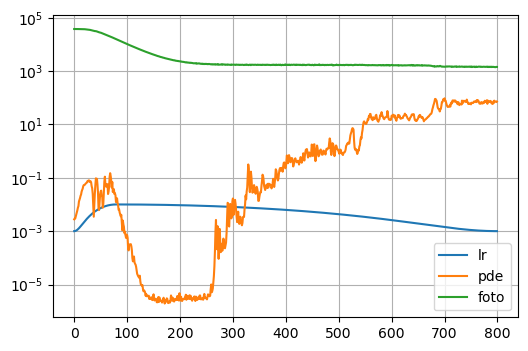

In [19]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

(200, 200)
float64


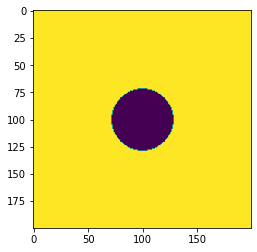

In [20]:
print(ini_circle.shape)
print(ini_circle.dtype)
plt.imshow(ini_circle)


In [85]:
x = np.linspace(0,199,200)
y = np.linspace(0,199,200)
t=50

grid=cart_prod(x,y,t)
xs, ys= grid[:, 0:1], grid[:,1:2]

X = torch.from_numpy(grid).float().to(device)
image_final =  pde.eval(X)

xs, ys= grid[:, 0:1], grid[:,1:2]
print(image_final.shape)
print(image_final.dtype)

#plt.imshow(f_circle(xs,ys).reshape(200,200))

torch.Size([40000, 1])
torch.float32


In [86]:
imashow=image_final.reshape(200,200)

In [87]:
def float_to_int(imashow):
    for i in range(len(imashow)):
        for j in range (len(imashow)):
            imashow[i][j]=int(imashow[i][j])

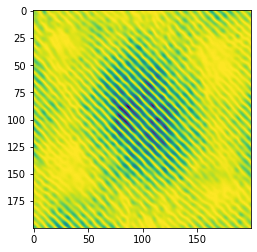

In [88]:
#float_to_int(imashow)
plt.imshow(imashow)

In [89]:
from skimage import io
io.imsave(".\\images_perona\\circ_1.6_t50.jpg",imashow)

Lossy conversion from float32 to uint8. Range [127.46781158447266, 193.96633911132812]. Convert image to uint8 prior to saving to suppress this warning.


In [25]:
for i in range(len(imashow)):
    pass
len(imashow[0])

200

In [26]:
print(imashow)

tensor([[192.1090, 192.7860, 189.2651,  ..., 192.6923, 189.2551, 186.1605],
        [189.6580, 192.9490, 192.7884,  ..., 193.7793, 192.6192, 189.8608],
        [187.1854, 190.8340, 193.1440,  ..., 192.1212, 193.7111, 192.9138],
        ...,
        [192.7885, 191.7884, 187.6613,  ..., 187.7375, 187.7248, 189.0206],
        [187.7207, 191.3931, 191.3662,  ..., 190.3127, 188.3792, 188.0598],
        [180.2440, 185.6309, 189.5905,  ..., 192.8686, 190.2290, 188.0212]])


In [27]:
def matrix_substract(a,b):
    res=np.zeros_like(a)
    for i in range(len(a)):
        for j in range(len(a[0])):
            res[i][j]=abs(abs(a[i][j])-abs(b[i][j]))
            
    return res

In [28]:
sub=matrix_substract(ini_circle,imashow)
sum=0
for i in range(len(sub)):
        for j in range(len(sub[0])):
            sum+=sub[i][j]
print(   sum/  (  len(sub)*len(sub[0])  )   )

21.075442200469972


Ponemos de sampler el perona sampler para el modelo